In [55]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from numpy import asarray
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

In [56]:
%store -r df_cleaned

In [57]:
df_cleaned

week     wPreis  \
date                             
2020-09-14  2020-37 -37.519318   
2020-09-14  2020-37 -37.519318   
2020-09-14  2020-37 -23.445068   
2020-09-14  2020-37 -36.379163   
2020-09-14  2020-37 -27.983877   
...             ...        ...   
2024-04-22  2024-17   7.216049   
2024-04-22  2024-17  33.349057   
2024-04-22  2024-17   2.409250   
2024-04-22  2024-17  10.850000   
2024-04-22  2024-17  40.367961   

                                                         Plz  \
date                                                           
2020-09-14                                      ['25', '24']   
2020-09-14                                      ['25', '24']   
2020-09-14  ['80', '81', '82', '83', '84', '85', '93', '94']   
2020-09-14              ['70', '71', '73', '74', '75', '76']   
2020-09-14                                      ['25', '24']   
...                                                      ...   
2024-04-22                          ['50', '51', '52', '53']   
2024-04-22              ['70', '71', '73', '74', '75', '76']   
2024-04-22                                      ['25', '24']   
2024-04-22                                ['26', '27', '28']   
2024-04-22  ['80', '81', '82', '83', '84', '85', '93', '94']   

                               full       date  
date                                            
2020-09-14       A2 -  geschreddert 2020-09-14  
2020-09-14  A1 & A2 -  geschreddert 2020-09-14  
2020-09-14       A3 -  geschreddert 2020-09-14  
2020-09-14  A2 & A3 -  geschreddert 2020-09-14  
2020-09-14  A2 & A3 -  geschreddert 2020-09-14  
...                             ...        ...  
2024-04-22  A2 & A3 -  geschreddert 2024-04-22  
2024-04-22  A2 & A3 -  geschreddert 2024-04-22  
2024-04-22       A2 -  geschreddert 2024-04-22  
2024-04-22       A3 -  geschreddert 2024-04-22  
2024-04-22  A2 & A3 -  geschreddert 2024-04-22  

[5773 rows x 5 columns]

Extracting one cluster from the dataset for analysis.

In [58]:
df = df_cleaned

In [59]:
TS1 = df[(df['Plz'] == "['25', '24']")]

And from this cluster, extracting one category for analysis.

In [60]:
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']

In [61]:
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [62]:
datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]

# Plotting ACF and PACF

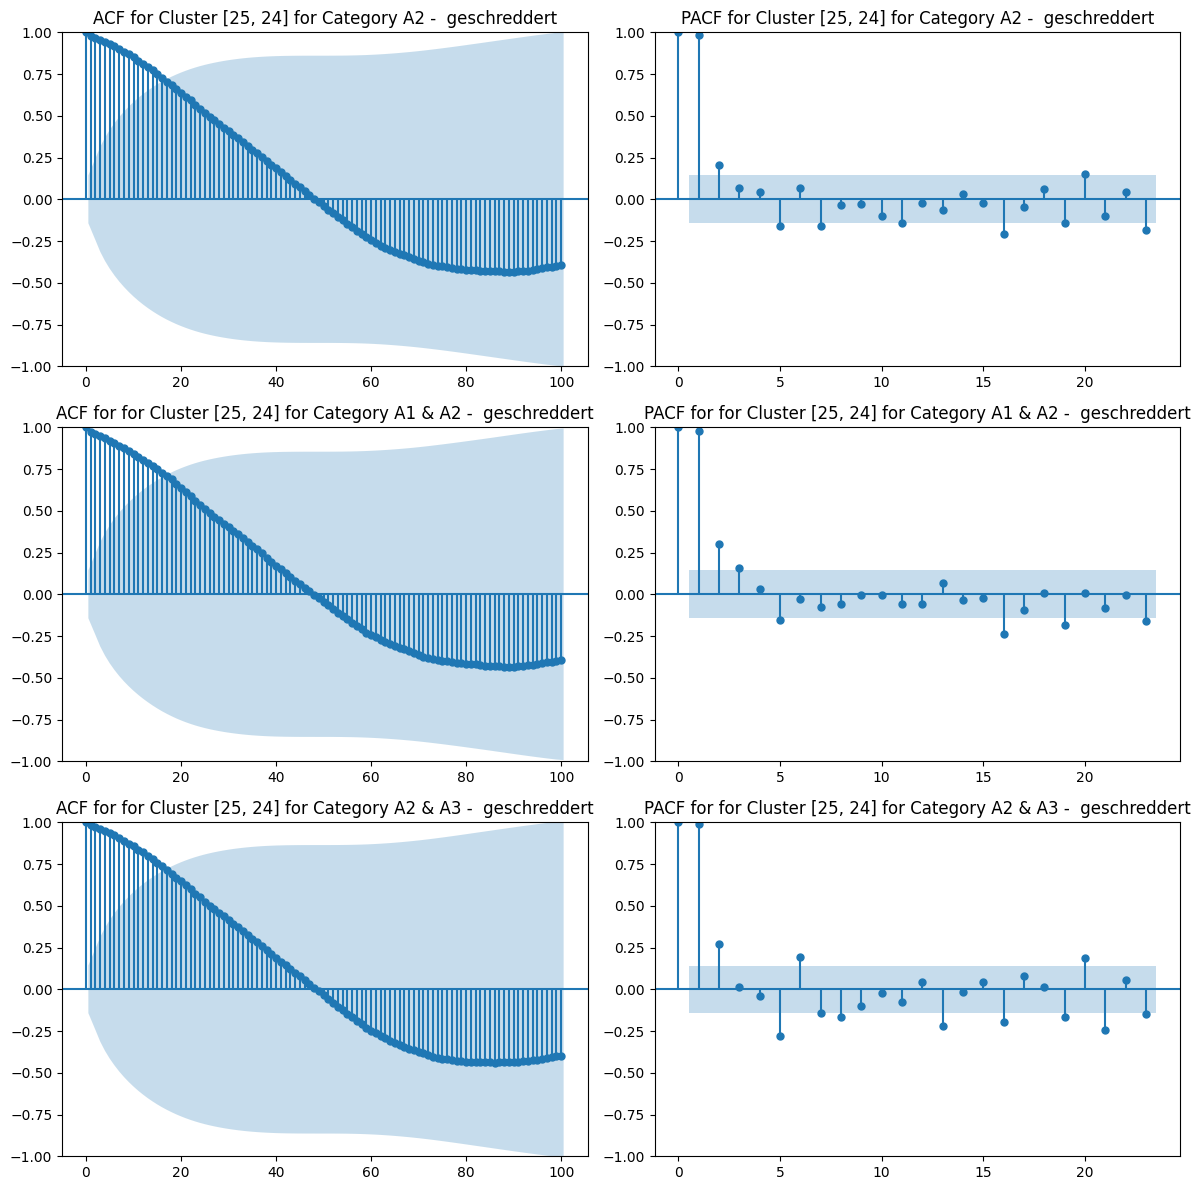

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# ACF and PACF for TS1_A2
plot_acf(TS1_A2['wPreis'], lags=100, ax=axes[0, 0])
axes[0, 0].set_title('ACF for Cluster [25, 24] for Category A2 -  geschreddert')
plot_pacf(TS1_A2['wPreis'], ax=axes[0, 1])
axes[0, 1].set_title('PACF for Cluster [25, 24] for Category A2 -  geschreddert')

# ACF and PACF for TS1_A1A2
plot_acf(TS1_A1A2['wPreis'], lags=100, ax=axes[1, 0])
axes[1, 0].set_title('ACF for for Cluster [25, 24] for Category A1 & A2 -  geschreddert')
plot_pacf(TS1_A1A2['wPreis'], ax=axes[1, 1])
axes[1, 1].set_title('PACF for for Cluster [25, 24] for Category A1 & A2 -  geschreddert')

# ACF and PACF for TS1_A2A3
plot_acf(TS1_A2A3['wPreis'], lags=100, ax=axes[2, 0])
axes[2, 0].set_title('ACF for for Cluster [25, 24] for Category A2 & A3 -  geschreddert')
plot_pacf(TS1_A2A3['wPreis'], ax=axes[2, 1])
axes[2, 1].set_title('PACF for for Cluster [25, 24] for Category A2 & A3 -  geschreddert')

plt.tight_layout()
plt.show()


- The ACF plots show that there is a positive correlation with the first 10-to-15 lags and it decreases backwards in time until it becomes less significant after around 15 weeks.

- The PACF plots show high correlation for 1 week lag but that is expected. Around 20 weeks, there seems to be a high partial autocorrelation. But we don't read too much into it as this "category" is also a combination of multiple categories.

# Seasonal Decomposition

In [64]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [65]:
def plot_decomposition(TS, freq=4):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(TS, period=freq)

    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot original time series and components
    plt.figure(figsize=(16, 8))

    plt.subplot(411)
    plt.plot(TS, label="Original")
    plt.title("Decomposition with freq={} weeks".format(freq))
    plt.legend(loc="best")

    plt.subplot(412)
    plt.plot(trend, label="Trend")
    plt.legend(loc="best")

    plt.subplot(413)
    plt.plot(seasonal, label="Seasonality")
    plt.legend(loc="best")

    plt.subplot(414)
    plt.plot(residual, label="Residuals")
    plt.legend(loc="best")

    plt.tight_layout()
    plt.show()

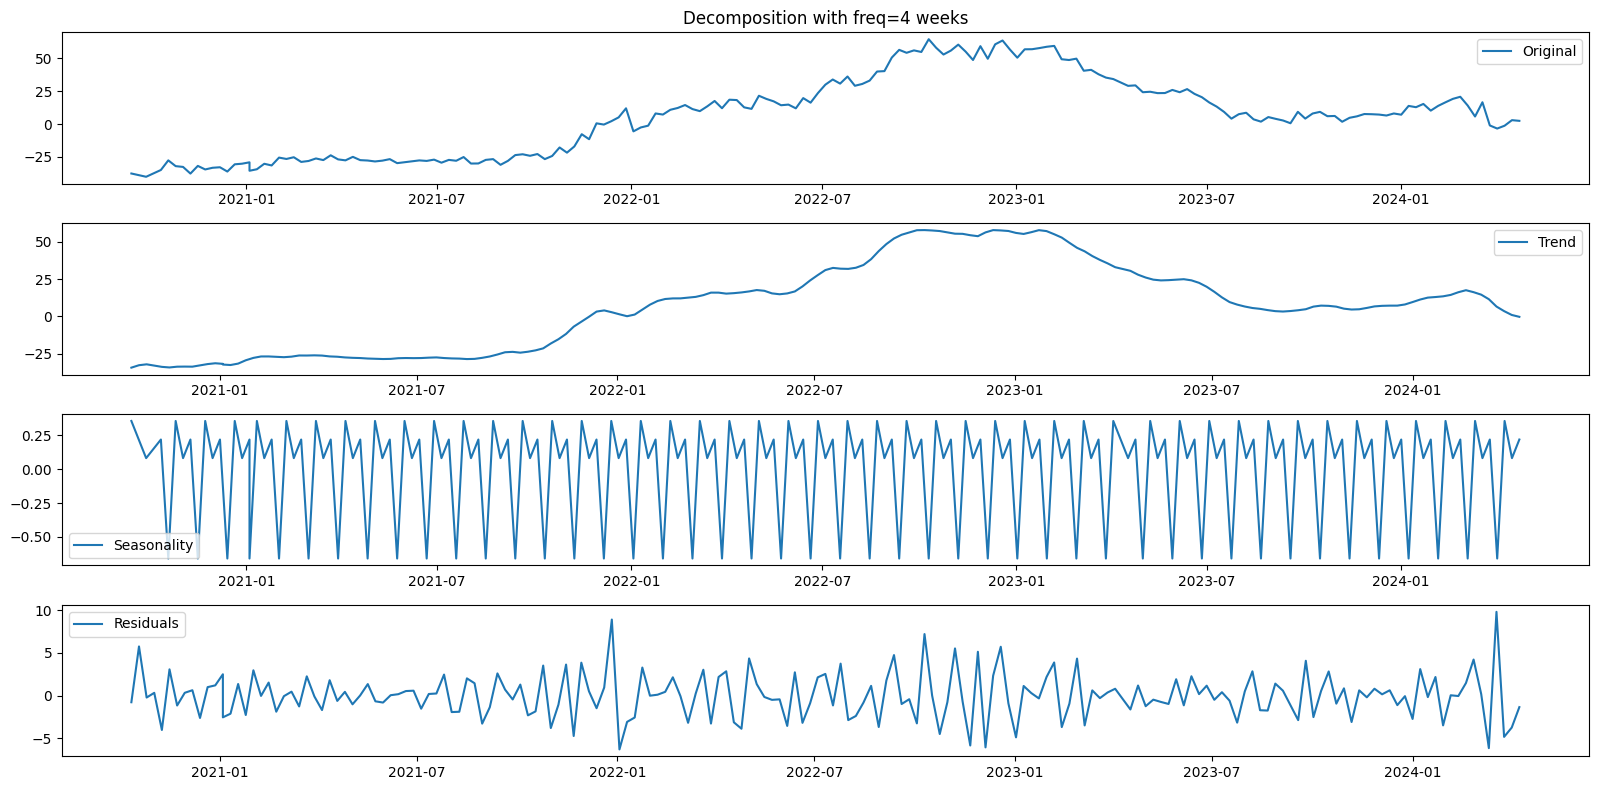

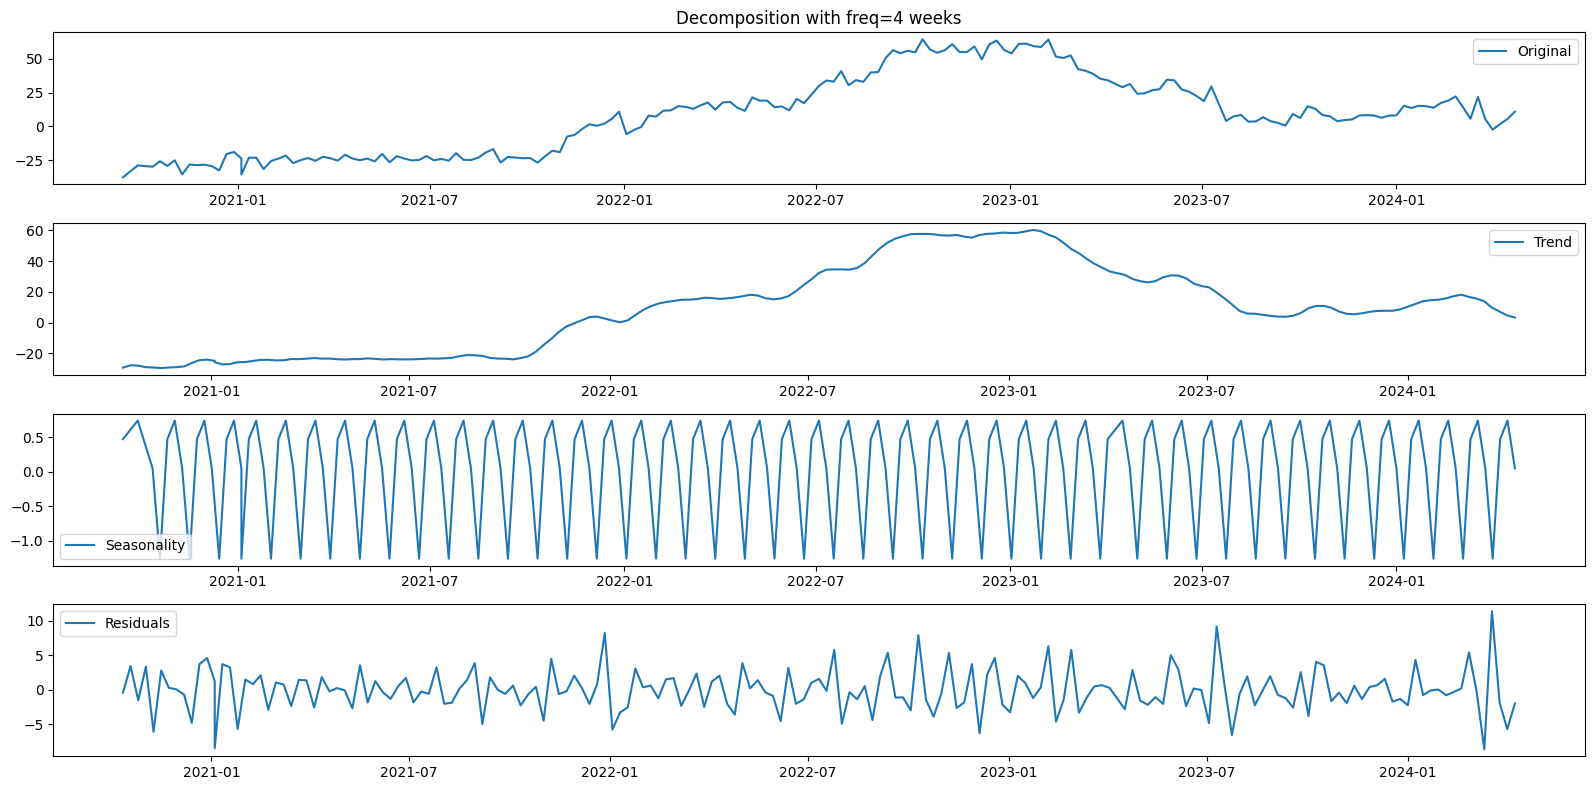

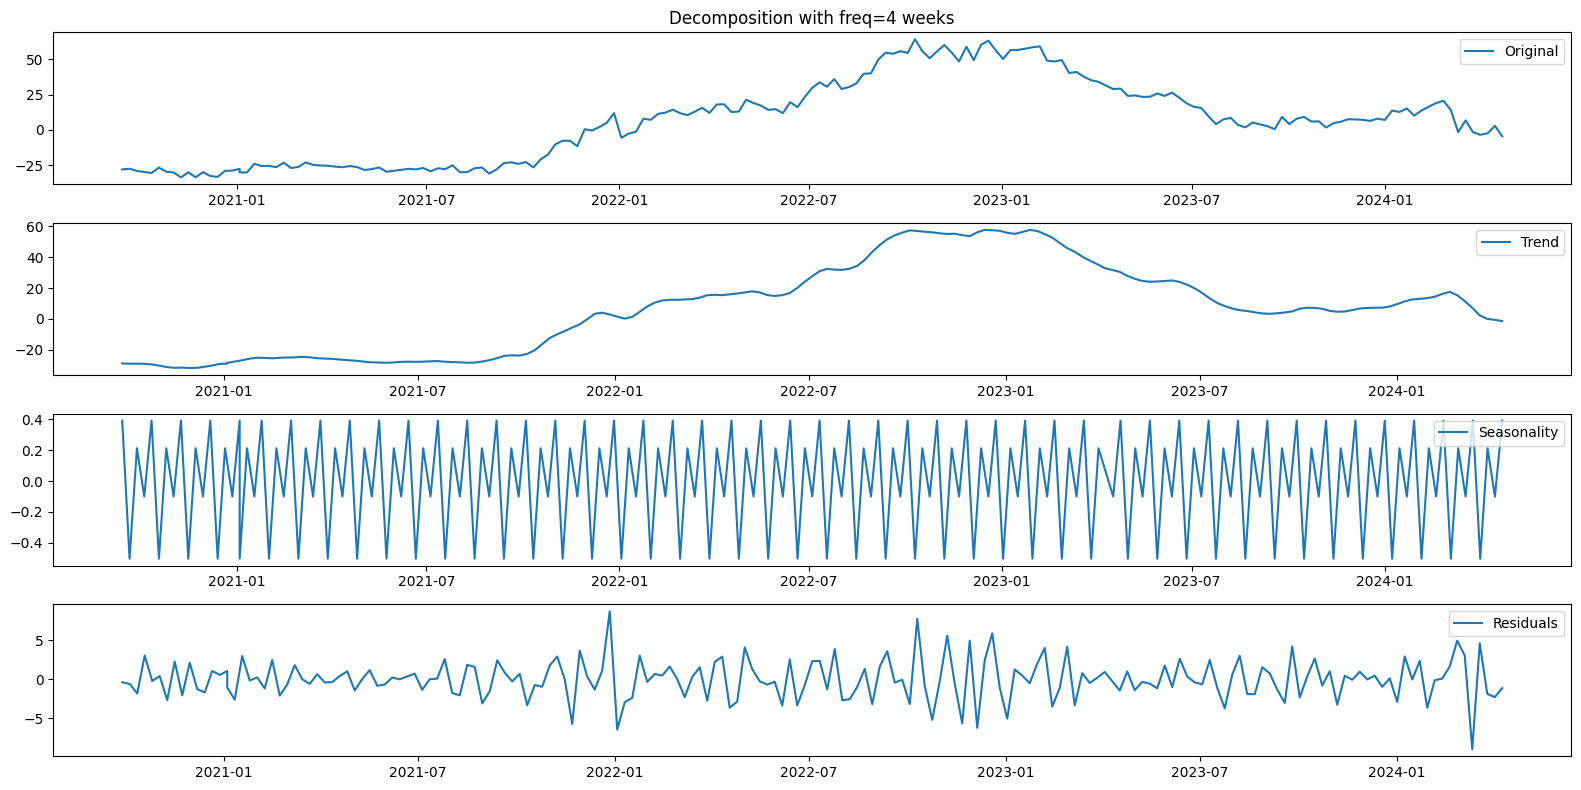

In [66]:
plot_decomposition(TS1_A2["wPreis"].dropna(), freq=4)
plot_decomposition(TS1_A1A2["wPreis"].dropna(), freq=4)
plot_decomposition(TS1_A2A3["wPreis"].dropna(), freq=4)

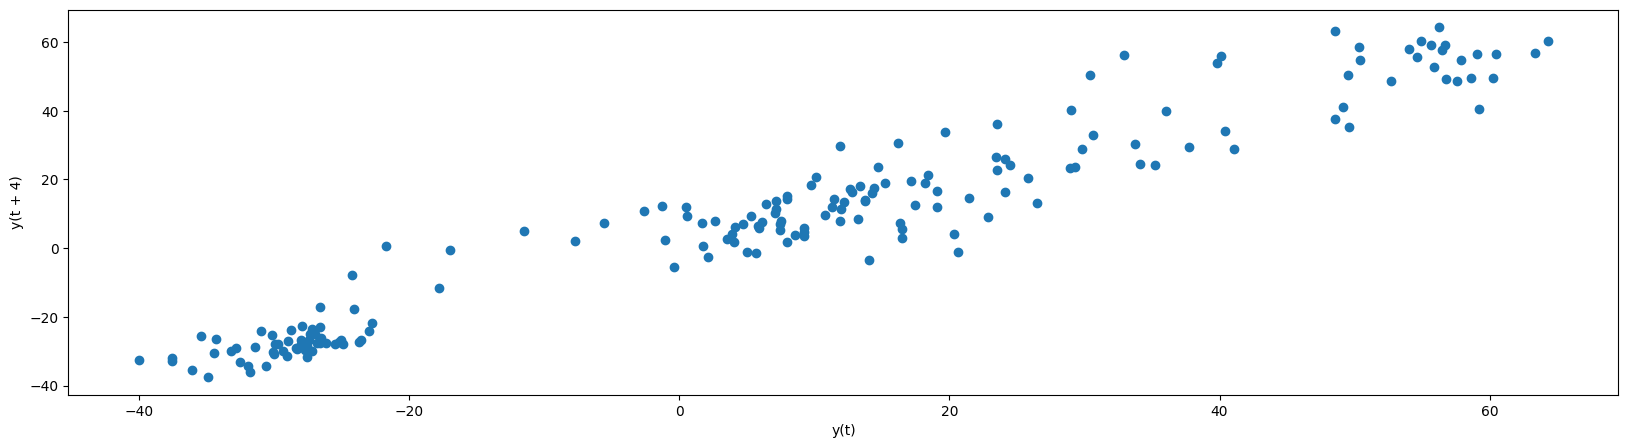

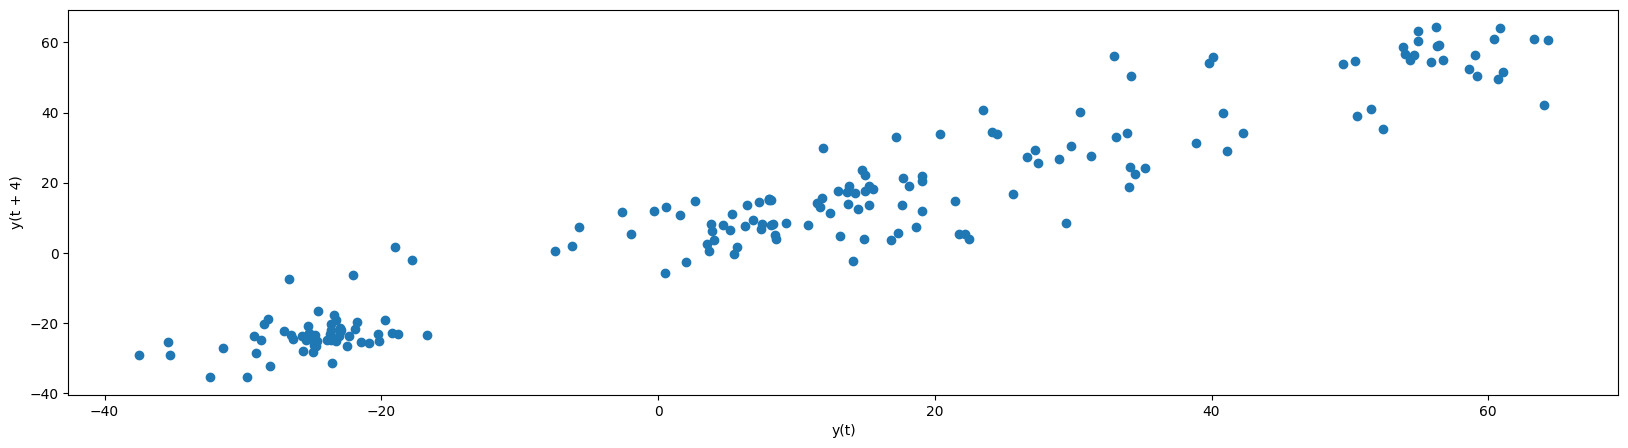

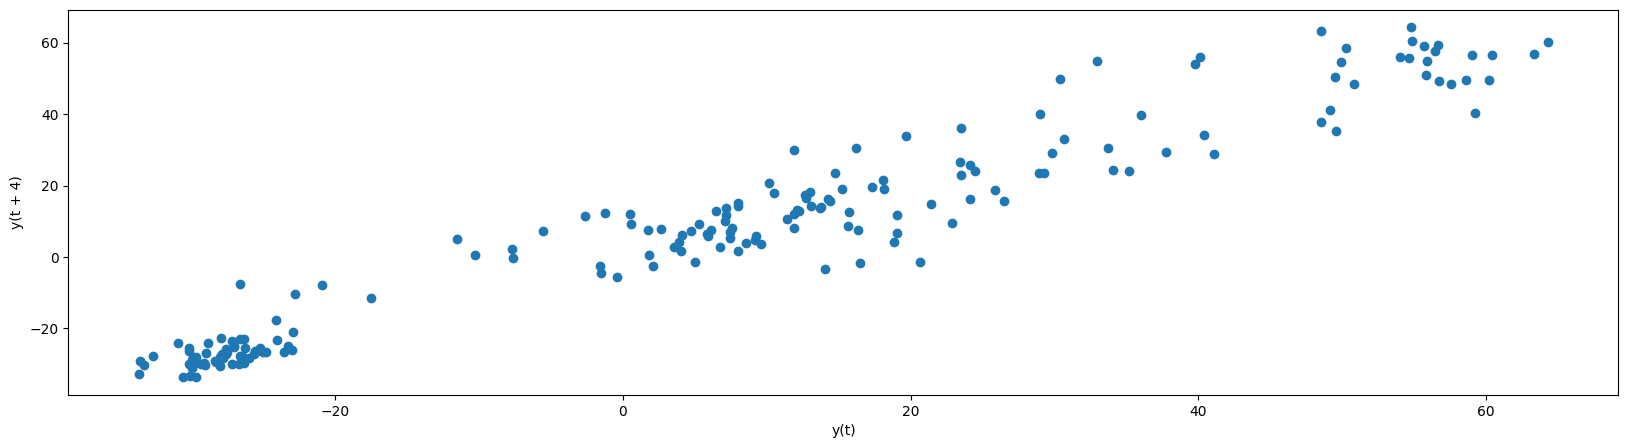

In [67]:
# Lag plot of LQC(coc_mpyn_prfr)
for dataset in datasets:
    plt.figure(figsize=(20,5))
    pd.plotting.lag_plot((dataset['wPreis']), lag= 4)

# Testing for Stationarity

In [68]:
from statsmodels.tsa.stattools import adfuller 

In [69]:
#Perform Dickey-Fuller test:
def test_stationarity(timeseries):    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items(): # key, value mapping
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[0] < dftest[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")

In [70]:
for dataset in datasets:
    category = dataset["full"].unique()
    cluster = dataset["Plz"].unique()
    print(f'Results of Dickey-Fuller Test for {category} in {cluster}:')
    test_stationarity(dataset["wPreis"])


Results of Dickey-Fuller Test for ['A2 -  geschreddert'] in ["['25', '24']"]:
Test Statistic                  -1.378535
p-value                          0.592522
#Lags Used                       4.000000
Number of Observations Used    182.000000
Critical Value (1%)             -3.466800
Critical Value (5%)             -2.877555
Critical Value (10%)            -2.575308
dtype: float64
Failed to Reject Ho - Time Series is Non-Stationary
Results of Dickey-Fuller Test for ['A1 & A2 -  geschreddert'] in ["['25', '24']"]:
Test Statistic                  -1.420392
p-value                          0.572462
#Lags Used                       4.000000
Number of Observations Used    182.000000
Critical Value (1%)             -3.466800
Critical Value (5%)             -2.877555
Critical Value (10%)            -2.575308
dtype: float64
Failed to Reject Ho - Time Series is Non-Stationary
Results of Dickey-Fuller Test for ['A2 & A3 -  geschreddert'] in ["['25', '24']"]:
Test Statistic                  -1

# Differencing

In [71]:
TS1_A2['full'].iloc[0]

'A2 -  geschreddert'

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_63927/2432771319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TS1_A2['wPreis_diff'] = TS1_A2['wPreis'].diff()


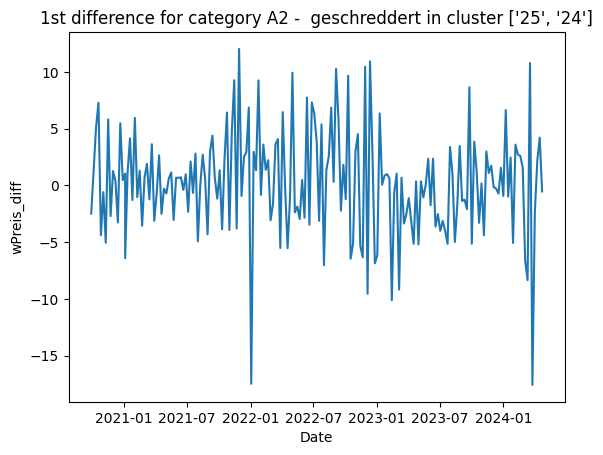

In [72]:
# category = TS1_A2['full'].unique()
# cluster = TS1_A2['Plz'].unique()
cluster = TS1_A2['Plz'].iloc[0]
category = TS1_A2['full'].iloc[0]
TS1_A2['wPreis_diff'] = TS1_A2['wPreis'].diff()
plt.xlabel('Date')
plt.ylabel('wPreis_diff')    
plt.title(f'1st difference for category {category} in cluster {cluster}')
plt.plot(TS1_A2['wPreis_diff'])

In [73]:
TS1_A2['wPreis_diff2'] = TS1_A2['wPreis_diff'].diff()

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_63927/92578211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TS1_A2['wPreis_diff2'] = TS1_A2['wPreis_diff'].diff()


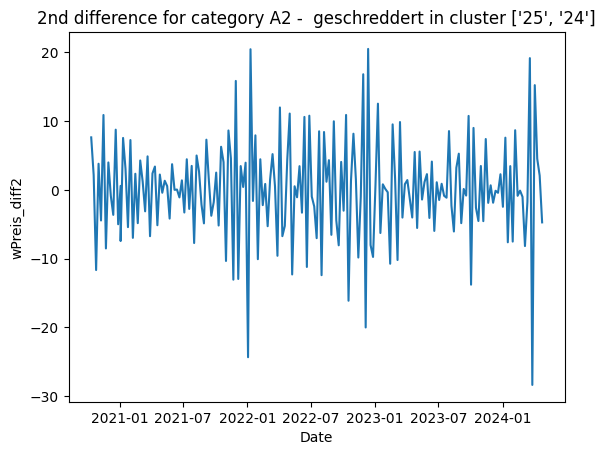

In [74]:
plt.xlabel('Date')
plt.ylabel('wPreis_diff2')    
plt.title(f'2nd difference for category {category} in cluster {cluster}')
plt.plot(TS1_A2['wPreis_diff2'])

In [75]:
TS1_A2.dropna(inplace = True)
print(f'Results of Dickey-Fuller Test for 1st differenced time series of {category} in {cluster}:')
test_stationarity(TS1_A2['wPreis_diff'])


Results of Dickey-Fuller Test for 1st differenced time series of A2 -  geschreddert in ['25', '24']:
Test Statistic                -5.870543e+00
p-value                        3.248068e-07
#Lags Used                     3.000000e+00
Number of Observations Used    1.810000e+02
Critical Value (1%)           -3.467005e+00
Critical Value (5%)           -2.877644e+00
Critical Value (10%)          -2.575355e+00
dtype: float64
Reject Ho - Time Series is Stationary


/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_63927/2262485836.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TS1_A2.dropna(inplace = True)


In [76]:
TS1_A2.dropna(inplace = True)
print(f'Results of Dickey-Fuller Test for 2nd differenced time series of {category} in {cluster}:')
test_stationarity(TS1_A2['wPreis_diff2'])


Results of Dickey-Fuller Test for 2nd differenced time series of A2 -  geschreddert in ['25', '24']:
Test Statistic                -8.803148e+00
p-value                        2.085874e-14
#Lags Used                     8.000000e+00
Number of Observations Used    1.760000e+02
Critical Value (1%)           -3.468062e+00
Critical Value (5%)           -2.878106e+00
Critical Value (10%)          -2.575602e+00
dtype: float64
Reject Ho - Time Series is Stationary


/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_63927/1808108016.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TS1_A2.dropna(inplace = True)


That was for the caetgory A2 -  geschreddert.
Now checking stationarity for A1 & A2 -  geschreddert. 

/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_63927/2210158322.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TS1_A1A2['wPreis_diff'] = TS1_A1A2['wPreis'].diff()
/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_63927/2210158322.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TS1_A1A2.dropna(inplace = True)


Results of Dickey-Fuller Test for 1st differenced time series of A1 & A2 -  geschreddert in ['25', '24']:
Test Statistic                -6.348625e+00
p-value                        2.644583e-08
#Lags Used                     3.000000e+00
Number of Observations Used    1.820000e+02
Critical Value (1%)           -3.466800e+00
Critical Value (5%)           -2.877555e+00
Critical Value (10%)          -2.575308e+00
dtype: float64
Reject Ho - Time Series is Stationary


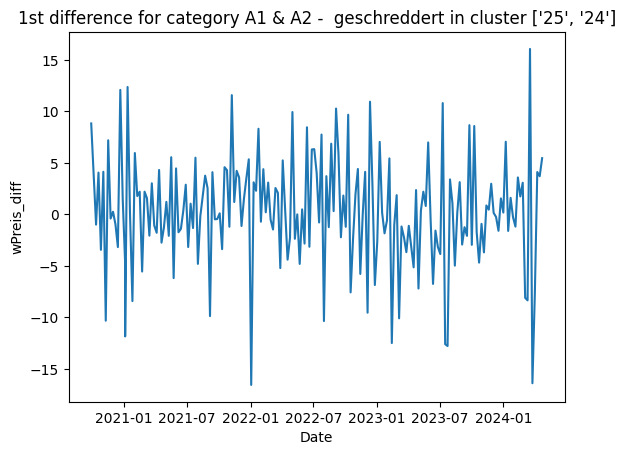

In [77]:
TS1_A1A2 # = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']

# category = TS1_A2['full'].unique()
# cluster = TS1_A2['Plz'].unique()
cluster = TS1_A1A2['Plz'].iloc[0]
category = TS1_A1A2['full'].iloc[0]
TS1_A1A2['wPreis_diff'] = TS1_A1A2['wPreis'].diff()
plt.xlabel('Date')
plt.ylabel('wPreis_diff')    
plt.title(f'1st difference for category {category} in cluster {cluster}')
plt.plot(TS1_A1A2['wPreis_diff'])

TS1_A1A2.dropna(inplace = True)
print(f'Results of Dickey-Fuller Test for 1st differenced time series of {category} in {cluster}:')
test_stationarity(TS1_A1A2['wPreis_diff'])

We have made it stationary. Now we can start modeling.

In [22]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [23]:
# Function to perform Dickey-Fuller test
def test_stationarity2(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    result = {}
    # result['Test Statistic'] = dftest[0]
    # result['p-value'] = dftest[1]
    # result['#Lags Used'] = dftest[2]
    # result['Number of Observations Used'] = dftest[3]
    # for key, value in dftest[4].items():
    #     result[f'Critical Value ({key})'] = value
    if dftest[0] < dftest[4]["5%"]:
        result['Stationary/Non-Stationary'] = 'Stationary'
    else:
        result['Stationary/Non-Stationary'] = 'Non-Stationary'
    return result

# List to hold results
results_list = []

# Loop through each dataset
for dataset in datasets:
    category = dataset['full'].unique()[0]
    cluster = dataset['Plz'].unique()[0]
    #print(f'Results of Dickey-Fuller Test for {category} in {cluster}:')
    
    # Perform test on original series
    orig_result = test_stationarity2(dataset['wPreis'])
    
    # Perform test on 1st difference
    diff1_result = test_stationarity2(dataset['wPreis'].diff().dropna())
    
    # Perform test on 2nd difference
    diff2_result = test_stationarity2(dataset['wPreis'].diff().diff().dropna())
    
    # Append results to list
    results_list.append({
        'Time series': f'{category} in {cluster}',
        'Stationary/Non-Stationary': orig_result['Stationary/Non-Stationary'],
        '1st difference': diff1_result['Stationary/Non-Stationary'],
        '2nd difference': diff2_result['Stationary/Non-Stationary']
    })

# Convert list of dictionaries to DataFrame
results_df = pd.DataFrame(results_list)
results_df

Time series  \
0                  A2 -  geschreddert in ['25', '24']   
1             A1 & A2 -  geschreddert in ['25', '24']   
2             A2 & A3 -  geschreddert in ['25', '24']   
3   A3 -  geschreddert in ['80', '81', '82', '83',...   
4   A1 & A2 -  geschreddert in ['80', '81', '82', ...   
5   A2 & A3 -  geschreddert in ['80', '81', '82', ...   
6   A2 & A3 -  geschreddert in ['70', '71', '73', ...   
7   A2 & A3 -  geschreddert in ['50', '51', '52', ...   
8      A3 -  geschreddert in ['50', '51', '52', '53']   
9   A2 & A3 -  ungeschreddert in ['40', '41', '42'...   
10  A1 & A2 -  ungeschreddert in ['40', '41', '42'...   
11  A2 & A3 -  geschreddert in ['40', '41', '42', ...   
12  A3 -  geschreddert in ['40', '41', '42', '44',...   
13  A1 & A2 -  geschreddert in ['40', '41', '42', ...   
14  A2 -  geschreddert in ['40', '41', '42', '44',...   
15           A2 -  geschreddert in ['26', '27', '28']   
16           A3 -  geschreddert in ['26', '27', '28']   
17      A1 & A2 -  geschreddert in ['26', '27', '28']   
18      A2 & A3 -  geschreddert in ['26', '27', '28']   
19          A2 & A3 -  ungeschreddert in ['48', '49']   
20               A3 -  ungeschreddert in ['48', '49']   
21            A2 & A3 -  geschreddert in ['48', '49']   
22            A1 & A2 -  geschreddert in ['48', '49']   
23                 A3 -  geschreddert in ['48', '49']   
24     A2 -  geschreddert in ['20', '21', '22', '23']   
25  A1 & A2 -  geschreddert in ['20', '21', '22', ...   
26  A2 & A3 -  geschreddert in ['20', '21', '22', ...   
27  A2 & A3 -  geschreddert in ['10', '11', '12', ...   
28  A1 & A2 -  geschreddert in ['10', '11', '12', ...   
29  A2 -  geschreddert in ['10', '11', '12', '13',...   
30  A2 & A3 -  geschreddert in ['29', '30', '31', ...   
31  A1 & A2 -  geschreddert in ['29', '30', '31', ...   
32  A2 -  geschreddert in ['29', '30', '31', '38',...   

   Stationary/Non-Stationary  1st difference 2nd difference  
0             Non-Stationary      Stationary     Stationary  
1             Non-Stationary      Stationary     Stationary  
2             Non-Stationary      Stationary     Stationary  
3             Non-Stationary      Stationary     Stationary  
4             Non-Stationary      Stationary     Stationary  
5             Non-Stationary      Stationary     Stationary  
6             Non-Stationary      Stationary     Stationary  
7             Non-Stationary  Non-Stationary     Stationary  
8             Non-Stationary      Stationary     Stationary  
9             Non-Stationary  Non-Stationary     Stationary  
10            Non-Stationary      Stationary     Stationary  
11            Non-Stationary      Stationary     Stationary  
12            Non-Stationary  Non-Stationary     Stationary  
13            Non-Stationary      Stationary     Stationary  
14            Non-Stationary      Stationary     Stationary  
15            Non-Stationary      Stationary     Stationary  
16            Non-Stationary      Stationary     Stationary  
17            Non-Stationary      Stationary     Stationary  
18            Non-Stationary      Stationary     Stationary  
19            Non-Stationary      Stationary     Stationary  
20            Non-Stationary      Stationary     Stationary  
21            Non-Stationary      Stationary     Stationary  
22            Non-Stationary      Stationary     Stationary  
23            Non-Stationary      Stationary     Stationary  
24            Non-Stationary      Stationary     Stationary  
25            Non-Stationary      Stationary     Stationary  
26            Non-Stationary  Non-Stationary     Stationary  
27            Non-Stationary      Stationary     Stationary  
28            Non-Stationary      Stationary     Stationary  
29            Non-Stationary      Stationary     Stationary  
30            Non-Stationary      Stationary     Stationary  
31            Non-Stationary      Stationary     Stationary  
32            Non-Stationary      Stationary     Stationa

In [24]:
print(results_df)

                                          Time series  \
0                  A2 -  geschreddert in ['25', '24']   
1             A1 & A2 -  geschreddert in ['25', '24']   
2             A2 & A3 -  geschreddert in ['25', '24']   
3   A3 -  geschreddert in ['80', '81', '82', '83',...   
4   A1 & A2 -  geschreddert in ['80', '81', '82', ...   
5   A2 & A3 -  geschreddert in ['80', '81', '82', ...   
6   A2 & A3 -  geschreddert in ['70', '71', '73', ...   
7   A2 & A3 -  geschreddert in ['50', '51', '52', ...   
8      A3 -  geschreddert in ['50', '51', '52', '53']   
9   A2 & A3 -  ungeschreddert in ['40', '41', '42'...   
10  A1 & A2 -  ungeschreddert in ['40', '41', '42'...   
11  A2 & A3 -  geschreddert in ['40', '41', '42', ...   
12  A3 -  geschreddert in ['40', '41', '42', '44',...   
13  A1 & A2 -  geschreddert in ['40', '41', '42', ...   
14  A2 -  geschreddert in ['40', '41', '42', '44',...   
15           A2 -  geschreddert in ['26', '27', '28']   
16           A3 -  geschreddert

In [91]:
!pip install tabulate


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip3 install --upgrade pip


In [92]:
from tabulate import tabulate



╒═════════════════════╤═════════╤═════════════╤══════════════════════════════════════════════════╤═══════════════════════════╤═════════════════════╕
│ date                │ week    │      wPreis │ Plz                                              │ full                      │ date                │
╞═════════════════════╪═════════╪═════════════╪══════════════════════════════════════════════════╪═══════════════════════════╪═════════════════════╡
│ 2020-09-14 00:00:00 │ 2020-37 │ -37.5193    │ ['25', '24']                                     │ A2 -  geschreddert        │ 2020-09-14 00:00:00 │
├─────────────────────┼─────────┼─────────────┼──────────────────────────────────────────────────┼───────────────────────────┼─────────────────────┤
│ 2020-09-14 00:00:00 │ 2020-37 │ -37.5193    │ ['25', '24']                                     │ A1 & A2 -  geschreddert   │ 2020-09-14 00:00:00 │
├─────────────────────┼─────────┼─────────────┼──────────────────────────────────────────────────┼────────

In [93]:
# Assuming df is your DataFrame
table = tabulate(results_df, headers='keys', tablefmt='fancy_grid')

# Print the formatted table
print(table)

╒════╤═════════════════════════════════════════════════════════════════════════════╤═════════════════════════════╤══════════════════╤══════════════════╕
│    │ Time series                                                                 │ Stationary/Non-Stationary   │ 1st difference   │ 2nd difference   │
╞════╪═════════════════════════════════════════════════════════════════════════════╪═════════════════════════════╪══════════════════╪══════════════════╡
│  0 │ A2 -  geschreddert in ['25', '24']                                          │ Non-Stationary              │ Stationary       │ Stationary       │
├────┼─────────────────────────────────────────────────────────────────────────────┼─────────────────────────────┼──────────────────┼──────────────────┤
│  1 │ A1 & A2 -  geschreddert in ['25', '24']                                     │ Non-Stationary              │ Stationary       │ Stationary       │
├────┼────────────────────────────────────────────────────────────────────────────

In [95]:
results_df.to_csv('Stationarity_test.csv')